### **VGG-16 on Horse2Zebra**

In [1]:
#Importing other libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#Importing Tensorflow
import tensorflow as tf
from tensorflow import keras
import os, cv2, random
!pip install tensorflow==2.8 
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip gdrive/MyDrive/archive.zip

Archive:  gdrive/MyDrive/archive.zip
replace metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: metadata.csv            
  inflating: testA/n02381460_1000.jpg  
  inflating: testA/n02381460_1010.jpg  
  inflating: testA/n02381460_1030.jpg  
  inflating: testA/n02381460_1090.jpg  
  inflating: testA/n02381460_1100.jpg  
  inflating: testA/n02381460_1110.jpg  
  inflating: testA/n02381460_1120.jpg  
  inflating: testA/n02381460_1160.jpg  
  inflating: testA/n02381460_120.jpg  
  inflating: testA/n02381460_1210.jpg  
  inflating: testA/n02381460_1260.jpg  
  inflating: testA/n02381460_1300.jpg  
  inflating: testA/n02381460_1350.jpg  
  inflating: testA/n02381460_1360.jpg  
  inflating: testA/n02381460_140.jpg  
  inflating: testA/n02381460_1420.jpg  
  inflating: testA/n02381460_1540.jpg  
  inflating: testA/n02381460_1620.jpg  
  inflating: testA/n02381460_1630.jpg  
  inflating: testA/n02381460_1660.jpg  
  inflating: testA/n02381460_1690.jpg  
  inflating: testA/n02381

In [4]:
for d in ['testA', 'testB', 'trainA', 'trainB']:
    dpath=os.path.join(d)
    labels=[]
    filepaths=[]
    flist=os.listdir(dpath)
    for f in flist:
        fpath=os.path.join(dpath,f)
        filepaths.append(fpath)
        if d=='testA' or d == 'trainA':
            labels.append('horse')
        else:
            labels.append('zebra')
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if d== 'testA':
        test_dfA=pd.concat([Fseries, Lseries], axis=1)
    elif d == 'testB':
        test_dfB=pd.concat([Fseries, Lseries], axis=1)
    elif d == 'trainA':
        dfA=pd.concat([Fseries, Lseries], axis=1)
    else:
        dfB=pd.concat([Fseries, Lseries], axis=1)
test_df=pd.concat([test_dfA, test_dfB], axis=0).reset_index(drop=True)
df=pd.concat([dfA, dfB], axis=0).reset_index(drop=True)
print (df['labels'].value_counts())
print (len(df))
print(test_df['labels'].value_counts())

zebra    1334
horse    1067
Name: labels, dtype: int64
2401
zebra    140
horse    120
Name: labels, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
train_split=.9
train_df, valid_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
print ('train samples: ', len(train_df),  ' validation samples', len(valid_df))
print (train_df['labels'].value_counts())

train samples:  2160  validation samples 241
zebra    1194
horse     966
Name: labels, dtype: int64


In [6]:
file_count = 966
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts())
print (len(df))

horse    966
zebra    966
Name: labels, dtype: int64
1932


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=80
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
trgen=ImageDataGenerator(preprocessing_function=scalar)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  65   test steps:  4
Found 2160 validated image filenames belonging to 2 classes.
Found 260 validated image filenames belonging to 2 classes.
Found 241 validated image filenames belonging to 2 classes.


In [9]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model.trainable = False #freeze the layers
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
import tensorflow as tf
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
history = model.fit(train_gen,
      epochs=10,
      validation_data=valid_gen,
      verbose=1)

Epoch 1/10
27/27 [==============================] - 20s 455ms/step - loss: 0.4152 - acc: 0.8148 - val_loss: 0.2073 - val_acc: 0.9544
Epoch 2/10
27/27 [==============================] - 11s 420ms/step - loss: 0.1802 - acc: 0.9458 - val_loss: 0.1288 - val_acc: 0.9793
Epoch 3/10
27/27 [==============================] - 13s 459ms/step - loss: 0.1311 - acc: 0.9671 - val_loss: 0.1082 - val_acc: 0.9917
Epoch 4/10
27/27 [==============================] - 12s 429ms/step - loss: 0.1073 - acc: 0.9718 - val_loss: 0.0931 - val_acc: 0.9917
Epoch 5/10
27/27 [==============================] - 12s 434ms/step - loss: 0.0919 - acc: 0.9773 - val_loss: 0.0877 - val_acc: 0.9917
Epoch 6/10
27/27 [==============================] - 13s 485ms/step - loss: 0.0803 - acc: 0.9819 - val_loss: 0.0771 - val_acc: 0.9917
Epoch 7/10
27/27 [==============================] - 12s 441ms/step - loss: 0.0711 - acc: 0.9856 - val_loss: 0.0731 - val_acc: 0.9959
Epoch 8/10
27/27 [==============================] - 13s 496ms/step - 

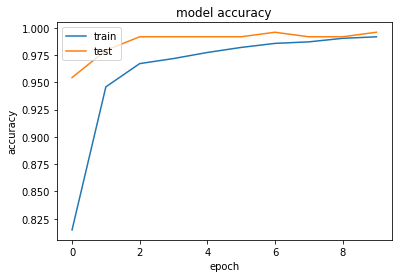

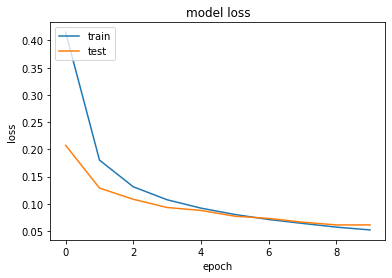

In [12]:
import matplotlib.pyplot as plt
#Plotting model Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plotting model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
print('Accuracy Score = ',np.max(history.history['val_acc']))

Accuracy Score =  0.9958506226539612


### **GoogleNet on Cats_and_dogs Dataset**

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model2.trainable = False #freeze the layers
base_model2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [15]:
model2 = tf.keras.Sequential([
    base_model2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model2.summary()

model2.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102402    
                                                                 
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
history2 = model2.fit(train_gen,
      epochs=10,
      validation_data=valid_gen,
      verbose=1)

Epoch 1/10
27/27 [==============================] - 16s 346ms/step - loss: 0.1170 - acc: 0.9523 - val_loss: 0.0173 - val_acc: 0.9917
Epoch 2/10
27/27 [==============================] - 7s 270ms/step - loss: 0.0228 - acc: 0.9931 - val_loss: 0.0207 - val_acc: 0.9876
Epoch 3/10
27/27 [==============================] - 7s 270ms/step - loss: 0.0111 - acc: 0.9972 - val_loss: 0.0114 - val_acc: 0.9959
Epoch 4/10
27/27 [==============================] - 7s 270ms/step - loss: 0.0047 - acc: 0.9991 - val_loss: 0.0126 - val_acc: 0.9959
Epoch 5/10
27/27 [==============================] - 7s 270ms/step - loss: 0.0033 - acc: 0.9995 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 6/10
27/27 [==============================] - 8s 297ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 7/10
27/27 [==============================] - 7s 269ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 8/10
27/27 [==============================] - 7s 269ms/step - loss: 0

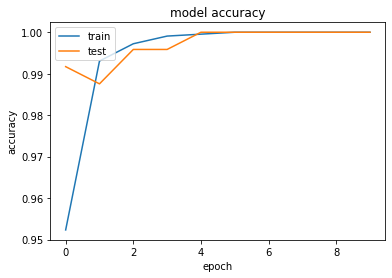

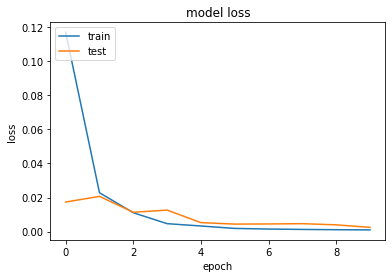

In [17]:
import matplotlib.pyplot as plt
#Plotting Accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plotting Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
print('Accuracy Score = ',np.max(history2.history['val_acc']))

Accuracy Score =  1.0


### **ResNet50 on Cats_and_Dogs Dataset**

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model3 = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model3.trainable = False #freeze the layers
base_model3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
model3 = tf.keras.Sequential([
    base_model3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model3.summary()

model3.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23,788,418
Trainable params: 200,706
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
history3 = model3.fit(train_gen,
      epochs=10,
      validation_data=valid_gen,
      verbose=1)

Epoch 1/10
27/27 [==============================] - 14s 359ms/step - loss: 0.7224 - acc: 0.6597 - val_loss: 0.4414 - val_acc: 0.7967
Epoch 2/10
27/27 [==============================] - 8s 301ms/step - loss: 0.3767 - acc: 0.8356 - val_loss: 0.3127 - val_acc: 0.8714
Epoch 3/10
27/27 [==============================] - 8s 302ms/step - loss: 0.3149 - acc: 0.8685 - val_loss: 0.2853 - val_acc: 0.8838
Epoch 4/10
27/27 [==============================] - 8s 300ms/step - loss: 0.2849 - acc: 0.8903 - val_loss: 0.2665 - val_acc: 0.8921
Epoch 5/10
27/27 [==============================] - 8s 300ms/step - loss: 0.2675 - acc: 0.8912 - val_loss: 0.2540 - val_acc: 0.8921
Epoch 6/10
27/27 [==============================] - 8s 298ms/step - loss: 0.2479 - acc: 0.9023 - val_loss: 0.2439 - val_acc: 0.8963
Epoch 7/10
27/27 [==============================] - 8s 297ms/step - loss: 0.2335 - acc: 0.9111 - val_loss: 0.2353 - val_acc: 0.9046
Epoch 8/10
27/27 [==============================] - 8s 300ms/step - loss: 0

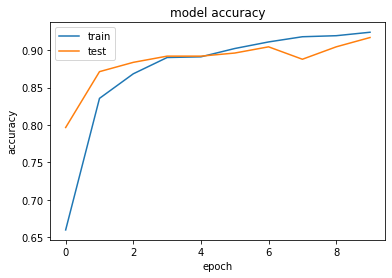

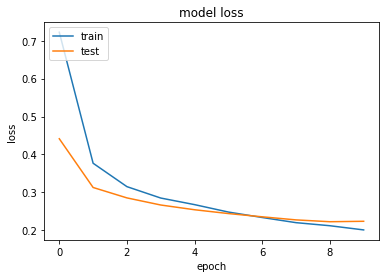

In [22]:
import matplotlib.pyplot as plt
#Plotting Accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plotting Loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
print('Accuracy Score = ',np.max(history3.history['val_acc']))

Accuracy Score =  0.9170124530792236


### **Efficient Net B0 on Cats_And_Dogs Dataset**

In [24]:
from tensorflow.keras.applications import EfficientNetB0
base_model4 = EfficientNetB0(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model4.trainable = False #freeze the layers
base_model4.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [25]:
model4 = tf.keras.Sequential([
    base_model4,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model4.summary()

model4.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 4,175,013
Trainable params: 125,442
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
history4 = model4.fit(train_gen,
      epochs=10,
      validation_data=valid_gen,
      verbose=1)

Epoch 1/10
27/27 [==============================] - 16s 351ms/step - loss: 0.7167 - acc: 0.5384 - val_loss: 0.7224 - val_acc: 0.4689
Epoch 2/10
27/27 [==============================] - 7s 266ms/step - loss: 0.6586 - acc: 0.5847 - val_loss: 0.5905 - val_acc: 0.5809
Epoch 3/10
27/27 [==============================] - 7s 266ms/step - loss: 0.6107 - acc: 0.6528 - val_loss: 0.5817 - val_acc: 0.7386
Epoch 4/10
27/27 [==============================] - 7s 266ms/step - loss: 0.6061 - acc: 0.6486 - val_loss: 0.5741 - val_acc: 0.7386
Epoch 5/10
27/27 [==============================] - 7s 266ms/step - loss: 0.5898 - acc: 0.6745 - val_loss: 0.5895 - val_acc: 0.6680
Epoch 6/10
27/27 [==============================] - 7s 267ms/step - loss: 0.5864 - acc: 0.6741 - val_loss: 0.6438 - val_acc: 0.5892
Epoch 7/10
27/27 [==============================] - 8s 285ms/step - loss: 0.6024 - acc: 0.6704 - val_loss: 0.5517 - val_acc: 0.6390
Epoch 8/10
27/27 [==============================] - 7s 265ms/step - loss: 0

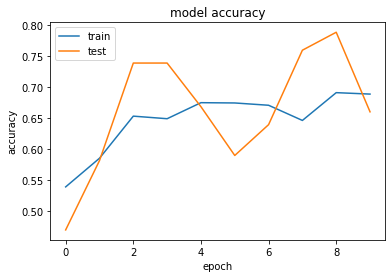

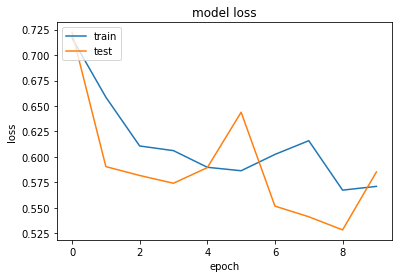

In [27]:
#Plotting Accuracy
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plotting Loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
print('Accuracy Score = ',np.max(history4.history['val_acc']))

Accuracy Score =  0.7883817553520203


### **MobileNetV2 on Cats_and_Dogs Dataset**

In [29]:
from tensorflow.keras.applications import MobileNetV2
base_model5 = MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
base_model5.trainable = False #freeze the layers
base_model5.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [30]:
model5 = tf.keras.Sequential([
    base_model5,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model5.summary()

model5.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['acc'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 125442    
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
history5 = model5.fit(train_gen,
      epochs=10,
      validation_data=valid_gen,
      verbose=1)

Epoch 1/10
27/27 [==============================] - 10s 287ms/step - loss: 0.1470 - acc: 0.9407 - val_loss: 0.0123 - val_acc: 0.9917
Epoch 2/10
27/27 [==============================] - 7s 246ms/step - loss: 0.0100 - acc: 0.9963 - val_loss: 0.0135 - val_acc: 0.9917
Epoch 3/10
27/27 [==============================] - 7s 245ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0090 - val_acc: 0.9959
Epoch 4/10
27/27 [==============================] - 7s 258ms/step - loss: 9.7580e-04 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9959
Epoch 5/10
27/27 [==============================] - 7s 244ms/step - loss: 7.1532e-04 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9959
Epoch 6/10
27/27 [==============================] - 7s 241ms/step - loss: 5.8597e-04 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9959
Epoch 7/10
27/27 [==============================] - 7s 245ms/step - loss: 5.0036e-04 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9959
Epoch 8/10
27/27 [==============================] - 7s 244m

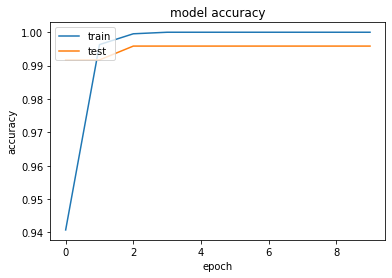

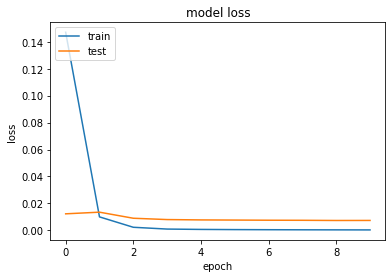

In [32]:
#Plotting Accuracy
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plotting Loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
print('Accuracy Score = ',np.max(history5.history['val_acc']))

Accuracy Score =  0.9958506226539612
